In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import contextily as cx
import os
import seaborn as sns
import shapely as shp

In [22]:
for csv_file in os.listdir("../data_clean"):
    if csv_file[-3:] == "csv":
        globals()[csv_file[:-4]] = pd.read_csv("../data_clean/" + csv_file)

In [30]:
new_cmap = matplotlib.colors.ListedColormap([
    [178/255, 194/255, 250/255], 
    [85/255, 148/255, 177/255], 
    [184/255, 228/255, 239/255], 
    [26/255, 63/255, 235/255], 
    [50/255, 88/255, 106/255]])
hue_order = ["Cergy", "Reims", "Avignon", "Montauban", "Clermont-Ferrand"]

# Analyse de la stratégie de routage
## Analyse du remplissage des camions

In [34]:
routes["fill_rate"] = routes["fill_volume"] / trucks["truck_volume"].iloc[0]

Text(0.5, 1.0, 'Distribution des taux de remplissage des camions')

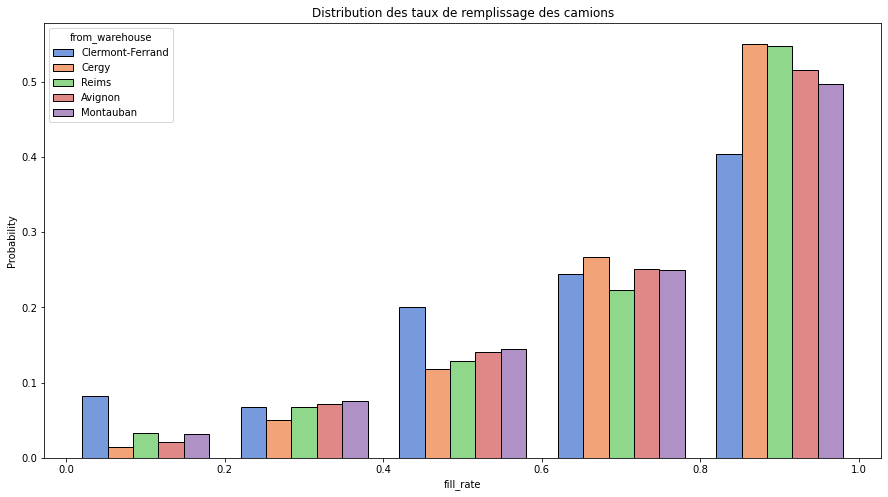

In [4]:
plt.figure(figsize=(15,8))
sns.histplot(x="fill_rate", hue="from_warehouse", data=routes, stat="probability", multiple="dodge", common_norm=False, bins=5, palette=sns.color_palette("muted")[:5], shrink=.80)
plt.title("Distribution des taux de remplissage des camions")

In [35]:
routes.fill_rate.mean()

0.7524997796515362

In [20]:
routes[["from_warehouse","fill_rate"]].to_csv("../beautiful_graphs/fill_rates.csv")

In [5]:
routes["n_route"] = 1
print(f"{len(routes[routes['fill_rate']<0.8])/len(routes) * 100:.0f}% des trajets voient leur camion rempli à moins de 80% !")
print(f"{len(routes[routes['fill_rate']<0.5])/len(routes) * 100:.0f}% des trajets voient leur camion rempli à moins de 50% !")

47% des trajets voient leur camion rempli à moins de 80% !
14% des trajets voient leur camion rempli à moins de 50% !


In [6]:
routes["route_date"] = pd.to_datetime(routes["route_date"])
df = routes[["route_date", "fill_rate", "from_warehouse"]].groupby(["route_date", "from_warehouse"]).agg("mean").reset_index()

In [7]:
df

,route_date,from_warehouse,fill_rate
0,2021-01-02,Cergy,0.096412
1,2021-01-02,Clermont-Ferrand,0.073697
2,2021-01-02,Reims,0.023266
3,2021-01-03,Avignon,0.043332
4,2021-01-03,Cergy,0.116737
...,...,...,...
888,2021-06-29,Avignon,0.728766
889,2021-06-29,Cergy,0.766974
890,2021-06-29,Clermont-Ferrand,0.778304
891,2021-06-29,Montauban,0.779547


In [8]:
dff = df.rolling(10, on="route_date").mean().join(df[["from_warehouse"]])

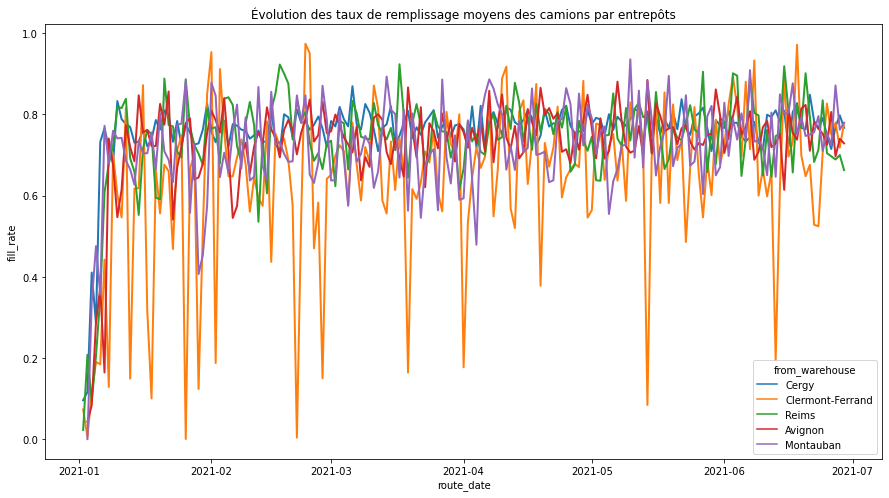

In [9]:
plt.figure(figsize=(15,8))
sns.lineplot(x="route_date", y="fill_rate", hue="from_warehouse", data=df, linewidth=2)
plt.title("Évolution des taux de remplissage moyens des camions par entrepôts")
plt.show()

On constate de nombreux pics, sans doute liés à la contrainte des 24h qui limitent les possibilités de lissage sur plusieurs jours.

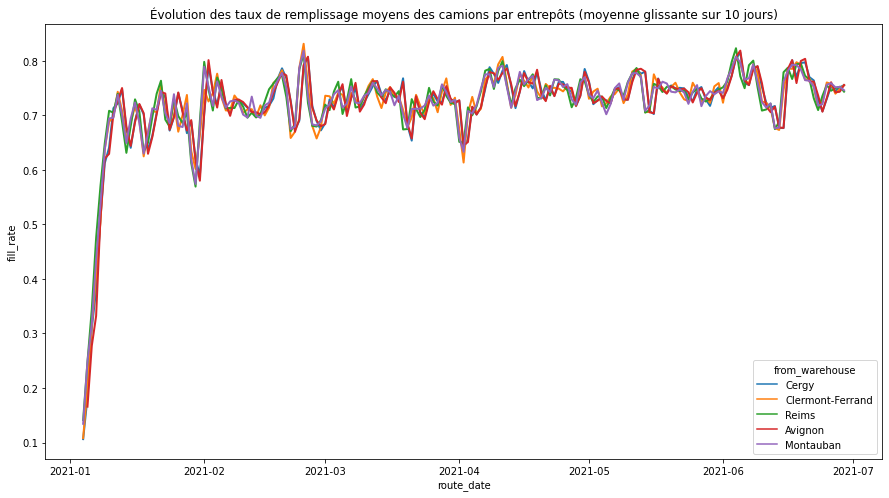

In [10]:
plt.figure(figsize=(15,8))
sns.lineplot(x="route_date", y="fill_rate", hue="from_warehouse", data=dff, linewidth=2)
plt.title("Évolution des taux de remplissage moyens des camions par entrepôts (moyenne glissante sur 10 jours)")
plt.show()

## Analyse du trajet des camions

In [11]:
routes

,Unnamed: 0,truck_id,duration,fill_volume,n_units,orders,from_warehouse,route_date,stops,total_distance,fill_rate,n_route
0,0,jehwGBpNg2rDLeKoYeiaLs,2.167136,5.9879,87.0,nK4iPf8nrGA9yivRH66ehS > jnsH9ndQ3UKcWSbb2UMkFn,Clermont-Ferrand,2021-01-02,Clermont-Ferrand > Bourges,153.950611,0.073697,1
1,1,XnzFnkALW3tLnzrdCVFyKH,23.230412,4.7060,190.0,XHfAWaLxTFbo5UQwtd7CMz > Wd6rPc4wPRNmt3ruf3F7o...,Cergy,2021-01-02,Cergy > Saint-Nazaire > Saint-Denis > Rouen > ...,1416.184102,0.057920,1
2,2,dwQ5Xd6TwcXURBczFdRXVy,6.995822,10.9609,148.0,gQi59MNfDa5YFpVWxfmPin > FaqH6N2zWCeykLh5f9VPW...,Cergy,2021-01-02,Cergy > Boulogne-Billancourt > Aubervilliers >...,184.704129,0.134903,1
3,3,A58tMgZVPfe2ucEBcCSXTW,4.785198,1.8904,79.0,7bzBdqUKWXyNrAhntXNrBq > BZsYUHDe4eVj7HaeM8MBt7,Reims,2021-01-02,Reims > Épinal > Troyes,390.851862,0.023266,1
4,4,KRNfDAmUV8bRzkxhdAYfkj,4.413343,0.4536,63.0,DfN8XqUVeVHjTW3Pat76Tr > MUT2TaTikTsi8FzSCnimxv,Clermont-Ferrand,2021-01-03,Clermont-Ferrand > Villeurbanne,139.447356,0.005583,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7421,7421,4q43tx2jAeJtMFz4UwGZpD,1.150110,68.8800,41.0,JXpxeURRDzSAgeE5FiPh7H,Montauban,2021-06-29,Montauban > Pessac,180.534974,0.847754,1
7422,7422,kRYyBXN9TeJF8Mewj55RdU,8.596979,69.6117,95.0,EpgfunMiFtk37q3hniS8Te > Cujg8Rgb8uvYWtSzA4y4a...,Montauban,2021-06-29,Montauban > Pessac > Perpignan > Pau,821.990387,0.856759,1
7423,7423,9LBChivrfyZZrBMpcjLtGv,21.367729,49.4855,307.0,bRay4XPtfJtqcfu9PcfHUN > Tn3ehPUBELhd3JxMPSD6f...,Montauban,2021-06-29,Montauban > Niort > Mérignac > Montauban > Lim...,1034.651961,0.609052,1
7424,7424,YjL2avoUgG3tdDxditdH5V,1.651791,79.3388,41.0,S254SKuGaFfScnCCyAUfWk > 9pvVqJzgLFF2PcypNjAc5V,Montauban,2021-06-29,Montauban > La Rochelle,308.878633,0.976478,1


In [12]:
def create_path(stops):
    stops = stops.split(" > ")
    coordinates = []
    for stop in stops:
        city = cities[cities["city"] == stop].iloc[0]
        coordinates.append([city["lng"], city["lat"]])
    if len(coordinates) == 1:
        coordinates = 2*coordinates
    return shp.geometry.LineString(coordinates)

In [25]:
routes["path"] = routes["stops"].apply(create_path)

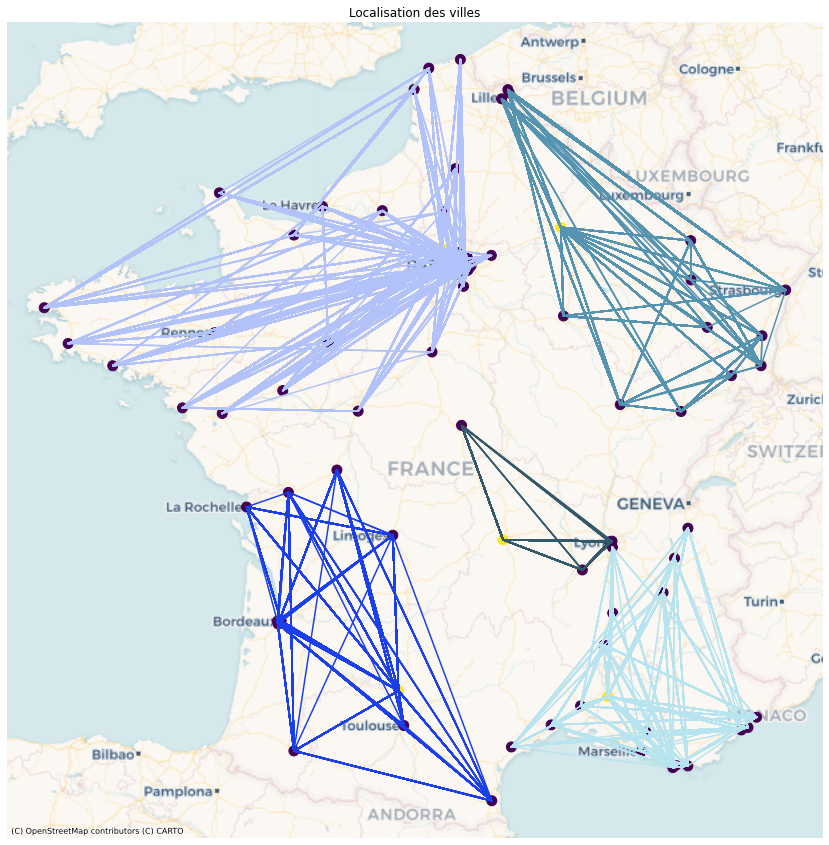

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lng, cities.lat), crs=4326)
gdf_cities.to_crs(epsg=3857).plot(ax=ax, column="is_warehouse", markersize=100)

gdf = gpd.GeoDataFrame(routes, geometry=routes.path, crs=4326)
gdf.to_crs(epsg=3857).plot(ax=ax, column="from_warehouse", cmap=new_cmap, legend=False, categories=hue_order)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, zoom=6)
ax.axis('off')
ax.set_title("Localisation des villes")
plt.show()

In [15]:
df = routes[["route_date", "total_distance", "from_warehouse"]].groupby(["route_date", "from_warehouse"]).agg("sum").reset_index()

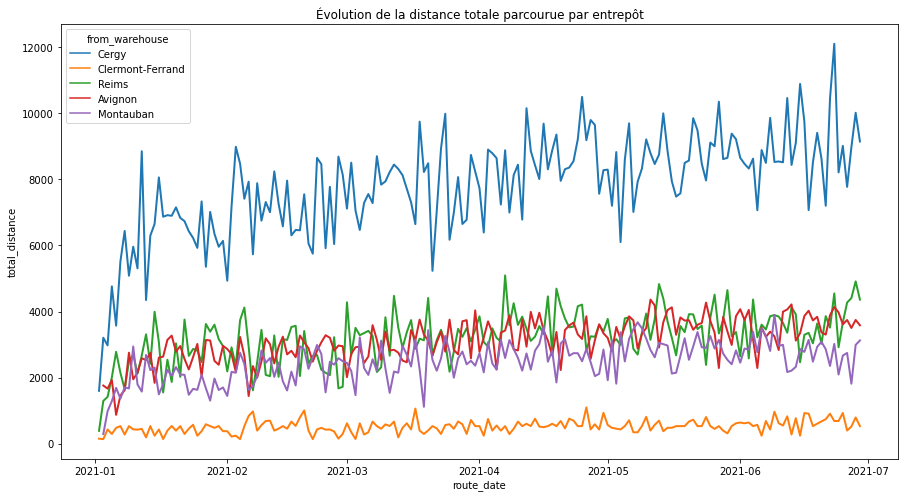

In [16]:
plt.figure(figsize=(15,8))
sns.lineplot(x="route_date", y="total_distance", hue="from_warehouse", data=df, linewidth=2)
plt.title("Évolution de la distance totale parcourue par entrepôt")
plt.show()